<a href="https://colab.research.google.com/github/samuelhurni/ML-Cellsegmentation-HSLU-FS24/blob/feature_Dev/ML_Project_Dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#imports
import os
import cv2
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim


In [ ]:
#drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
train_path= '/content/drive/MyDrive/ML_Project/sartorius-cell-instance-segmentation/train'
csv_path='/content/drive/MyDrive/ML_Project/sartorius-cell-instance-segmentation/train.csv'
#test_path= '/content/drive/"My Drive"/name_of_dataset_folder'
# os.chdir('/content/drive/MyDrive/ML_Project/sartorius-cell-instance-segmentation')

_, _, files = next(os.walk(train_path))
file_count = len(files)

annotations = pd.read_csv(csv_path)

height = annotations['height'][0]
width =  annotations['width'][0]

sample_ids = annotations['id'].unique()

print(len(sample_ids))
print(len(annotations))
print(file_count)
print(height)
print(width)

606
73585
606
520
704


In [ ]:
from PIL import Image

def decode_rle(rle_string, height, width):
    rle_numbers = list(map(int, rle_string.split()))
    mask = np.zeros(height * width, dtype=np.uint8)

    for start, length in zip(rle_numbers[0::2], rle_numbers[1::2]):
        start -= 1  # Convert to zero-indexed
        mask[start:start + length] = 1

    return mask.reshape((height, width))

data_dict = {}

ids = []
masks = []

for id in sample_ids:
  id_df = annotations[annotations['id'] == id]
  id_annotations = id_df['annotation']
  all_masks = []
  for annot in id_annotations:
    mask = decode_rle(annot, height, width)
    all_masks.append(mask)
  resultant_mask = all_masks[0]

  for mask in all_masks[1:]:
    resultant_mask = np.bitwise_or(resultant_mask, mask)

  ids.append(id)
  masks.append(resultant_mask)

data_dict['id'] = ids
data_dict['annotation'] = masks

annotations = pd.DataFrame(data_dict)

print(annotations.head())
print(len(annotations))


             id                                         annotation
0  0030fd0e6378  [[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
1  0140b3c8f445  [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
2  01ae5a43a2ab  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3  026b3c2c4b32  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
4  029e5b3b89c7  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
606


(520, 704)
(704, 520)


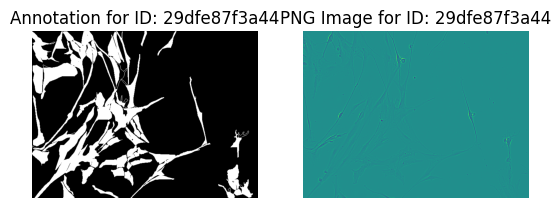

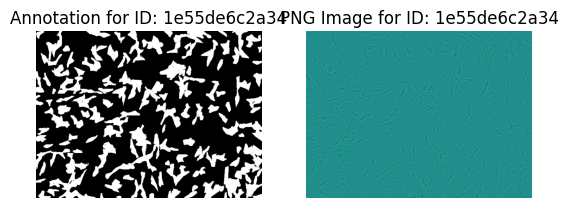

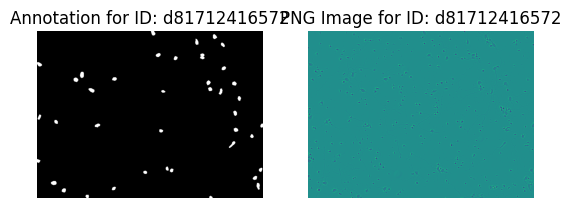

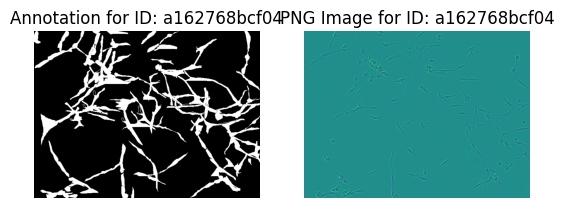

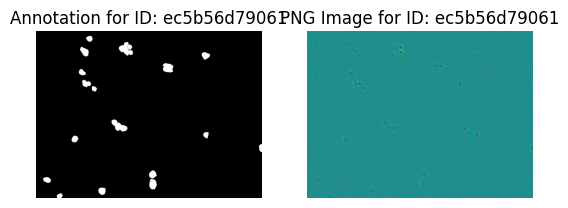

In [ ]:
random_rows = annotations.sample(n=5)

print(annotations['annotation'][0].shape)
img = Image.open(train_path + '/' + annotations['id'][0] + '.png')
print(img.size)

# Iterate over the selected random rows
for index, row in random_rows.iterrows():
    plt.subplot(1, 2, 1)
    plt.imshow(row['annotation'], cmap='gray')
    plt.title('Annotation for ID: ' + row['id'])
    plt.axis('off')

    # Load and display the corresponding PNG image based on the ID
    plt.subplot(1, 2, 2)
    img = Image.open(train_path + '/' + row['id'] + '.png')
    plt.imshow(img)
    plt.title('PNG Image for ID: ' + row['id'])
    plt.axis('off')

    plt.show()

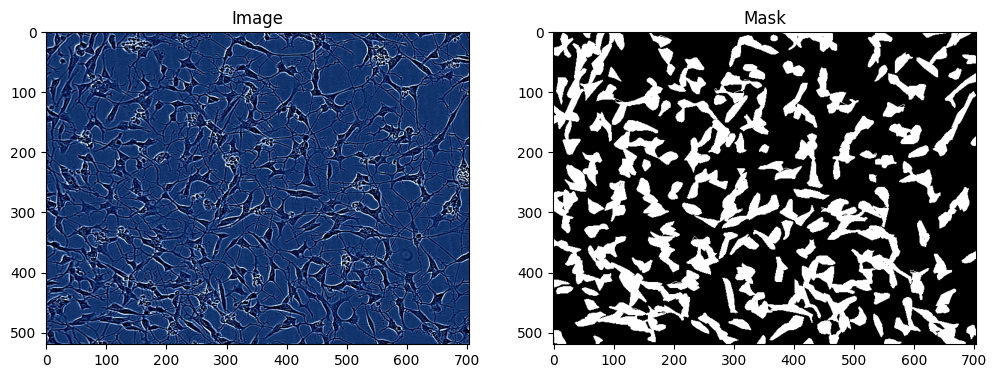

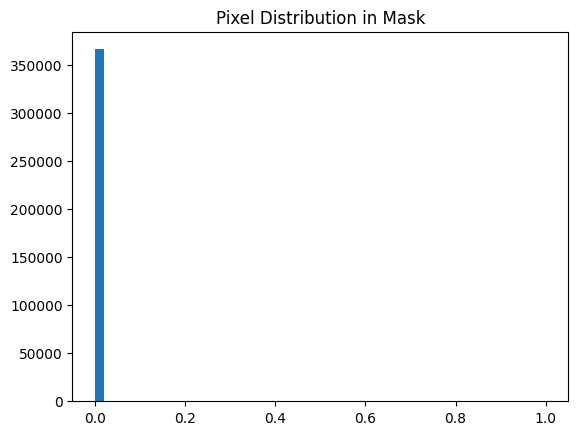

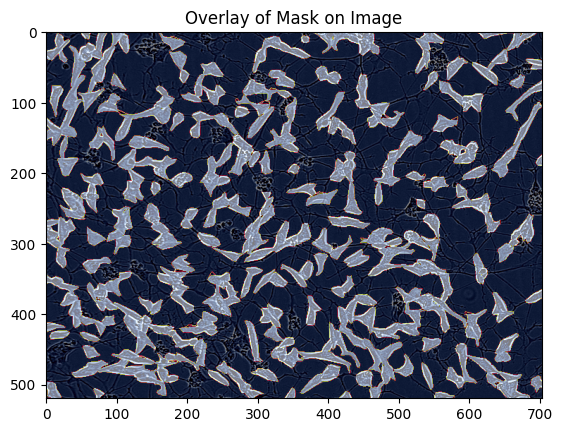

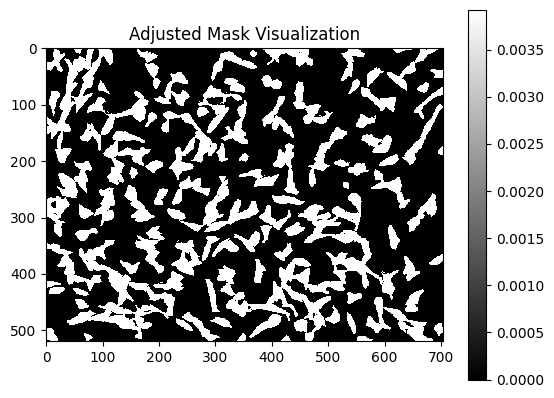

In [ ]:
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np
import os


from torchvision.transforms.functional import to_pil_image, to_tensor, hflip, vflip

class RandomHorizontalVerticalFlip:
    """Apply horizontal or vertical flip randomly to both image and mask."""
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image, mask):
        if torch.rand(1) < self.p:
            image = hflip(image)
            mask = hflip(mask)
        if torch.rand(1) < self.p:
            image = vflip(image)
            mask = vflip(mask)
        return image, mask

# Define the complete transformation for images and masks
def transform(image, mask):
    # Convert numpy image and mask to PIL for compatibility with torchvision transforms
    image = to_pil_image(image)
    mask = to_pil_image(mask)

    transform = RandomHorizontalVerticalFlip(p=0.5)
    image, mask = transform(image, mask)

    image = to_tensor(image)
    mask = to_tensor(mask)

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    image = normalize(image)

    return image, mask


class SartoriusDataset(Dataset):
    def __init__(self, annotations, img_dir, transform=None):
        self.annotations = annotations  # Assume annotations is already a DataFrame
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_id = self.annotations['id'][idx]

        img_path = os.path.join(self.img_dir, f'{img_id}.png')
        image = cv2.imread(img_path)

        if image is None:
            raise FileNotFoundError(f"No image found at {img_path}")

        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = self.annotations['annotation'][idx]

        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask


# Assuming 'annotations' is your DataFrame and 'train_path' is the directory where your images are stored


dataset = SartoriusDataset(annotations, train_path, transform=transform)

image, mask = dataset[0]  # Get the first sample

# Visualize the data
import matplotlib.pyplot as plt
import numpy as np

# Assuming `image` is a PyTorch tensor with shape (3, height, width)
# Convert it to a numpy array and transpose it to (height, width, 3) for visualization
if isinstance(image, torch.Tensor):
    image = image.permute(1, 2, 0).numpy()  # Rearrange dimensions
elif isinstance(image, np.ndarray):
    if image.ndim == 3 and image.shape[0] == 3:  # If it's in CHW format
        image = np.transpose(image, (1, 2, 0))  # Change to HWC for imshow

# Now use plt.imshow() to display the image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Image')

# Assuming `mask` is also a tensor and needs to be squeezed if it has a channel dimension
if isinstance(mask, torch.Tensor):
    mask = mask.squeeze().numpy()  # Remove channel dimension if it exists
elif isinstance(mask, np.ndarray) and mask.ndim == 3:
    mask = mask.squeeze()  # Squeeze to remove single-channel dimension for grayscale

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.show()

import matplotlib.pyplot as plt

# Example usage with a single RLE string and its corresponding size
example_rle = "10 5"  # This is a dummy example; replace it with an actual RLE from your dataset
shape = (100, 100)    # Replace with actual dimensions of the image



plt.hist(mask.ravel(), bins=50, range=[0,1])
plt.title('Pixel Distribution in Mask')
plt.show()

plt.imshow(image, cmap='gray')  # assuming image is grayscale
plt.imshow(mask, cmap='hot', alpha=0.5)  # overlay mask
plt.title('Overlay of Mask on Image')
plt.show()

plt.imshow(mask, cmap='gray', interpolation='none')
plt.colorbar()
plt.title('Adjusted Mask Visualization')
plt.show()



In [ ]:
import torch
import torch.nn as nn

class SmallUNet(nn.Module):
    def __init__(self):
        super(SmallUNet, self).__init__()

        # Define encoder (downsampling) path
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2)
        )

        # Define decoder (upsampling) path
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 32, 2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Define output layer
        self.output = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        # Forward pass through encoder
        x1 = self.encoder(x)

        # Forward pass through decoder
        x = self.decoder(x1)

        # Output layer
        x = self.output(x)

        return x


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

learning_rate = 0.01

total_size = len(dataset)
val_size = int(0.1 * total_size)  # 10% for validation
train_size = total_size - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Assuming you have already split your dataset into training and validation
total_size = len(dataset)  # Total number of images in the dataset
train_size = len(train_dataset)  # Number of training data samples
val_size = len(val_dataset)  # Number of validation data samples

print(f"Total number of data samples: {total_size}")
print(f"Number of training samples: {train_size}")
print(f"Number of validation samples: {val_size}")


train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

# Check the number of batches in the DataLoader and the number of samples per batch
num_batches = len(train_loader)
print(f"Number of batches in the training DataLoader: {num_batches}")


Using device: cuda
Total number of data samples: 606
Number of training samples: 546
Number of validation samples: 60
Number of batches in the training DataLoader: 137


In [ ]:

# Instantiate the U-Net model and move it to the appropriate device
model = SmallUNet().to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 10

# Lists to store training and validation loss
train_loss_history = []
val_loss_history = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_train_loss = 0.0

    pbar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

    # Training phase
    for images, masks in pbar:
        # Move data to the appropriate device
        images, masks = images.to(device), masks.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Calculate loss
        loss = criterion(outputs, masks)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        running_train_loss += loss.item()

    # Calculate average training loss for the epoch
    train_loss = running_train_loss / len(train_loader)
    train_loss_history.append(train_loss)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation for validation
        for val_images, val_masks in val_loader:
            # Move data to the appropriate device
            val_images, val_masks = val_images.to(device), val_masks.to(device)

            # Forward pass
            val_outputs = model(val_images)

            # Calculate validation loss
            val_loss = criterion(val_outputs, val_masks)

            # Accumulate validation loss
            running_val_loss += val_loss.item()

    # Calculate average validation loss for the epoch
    val_loss = running_val_loss / len(val_loader)
    val_loss_history.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss}, Validation Loss: {val_loss}")

print("Finished Training")


Epoch 1/10: 100%|██████████| 137/137 [00:35<00:00,  3.86it/s]


Epoch [1/10], Training Loss: 0.013808003301735641, Validation Loss: 0.003458601135450105


Epoch 2/10: 100%|██████████| 137/137 [00:35<00:00,  3.82it/s]


Epoch [2/10], Training Loss: 0.0036101792407915484, Validation Loss: 0.003305013842570285


Epoch 3/10: 100%|██████████| 137/137 [00:35<00:00,  3.87it/s]


Epoch [3/10], Training Loss: 0.0034969731979242044, Validation Loss: 0.0032730831027341385


Epoch 4/10: 100%|██████████| 137/137 [00:35<00:00,  3.83it/s]


Epoch [4/10], Training Loss: 0.0034428540783777942, Validation Loss: 0.003126809354095409


Epoch 5/10: 100%|██████████| 137/137 [00:35<00:00,  3.84it/s]


Epoch [5/10], Training Loss: 0.003347803694518949, Validation Loss: 0.003268707434957226


Epoch 6/10: 100%|██████████| 137/137 [00:35<00:00,  3.83it/s]


Epoch [6/10], Training Loss: 0.0033451867078254202, Validation Loss: 0.003216240477437774


Epoch 7/10: 100%|██████████| 137/137 [00:36<00:00,  3.80it/s]


Epoch [7/10], Training Loss: 0.003409623856066529, Validation Loss: 0.0032736064051277934


Epoch 8/10: 100%|██████████| 137/137 [00:35<00:00,  3.85it/s]


Epoch [8/10], Training Loss: 0.003333693557804668, Validation Loss: 0.003129954581769804


Epoch 9/10: 100%|██████████| 137/137 [00:35<00:00,  3.83it/s]


Epoch [9/10], Training Loss: 0.003279111611089214, Validation Loss: 0.003141241877650221


Epoch 10/10: 100%|██████████| 137/137 [00:35<00:00,  3.82it/s]


Epoch [10/10], Training Loss: 0.0032952573646648524, Validation Loss: 0.0030676239247744283
Finished Training


In [ ]:
# Validation loop
model.eval()  # Set the model to evaluation mode
val_loss = 0.0

# Create empty lists to store predicted masks and ground truth masks
predicted_masks = []
gt_masks = []
input_images = []

with torch.no_grad():  # Disable gradient calculation for validation
    for images, masks in val_loader:
        # Move data to the appropriate device
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)

        # Calculate loss
        loss = criterion(outputs, masks)

        # Accumulate validation loss
        val_loss += loss.item()

        # Convert outputs to probabilities and append to predicted masks list
        predicted_masks.append(torch.sigmoid(outputs).cpu().detach().numpy())

        # Append ground truth masks to gt_masks list
        gt_masks.append(masks.cpu().detach().numpy())

        input_images.append(images.cpu().detach().numpy())

# Compute average validation loss
avg_val_loss = val_loss / len(val_loader)
print(f"Validation Loss: {avg_val_loss}")

# Convert predicted_masks and gt_masks lists to numpy arrays
predicted_masks = np.concatenate(predicted_masks)
gt_masks = np.concatenate(gt_masks)
input_images = np.concatenate(input_images)

Validation Loss: 0.0030681910226121544


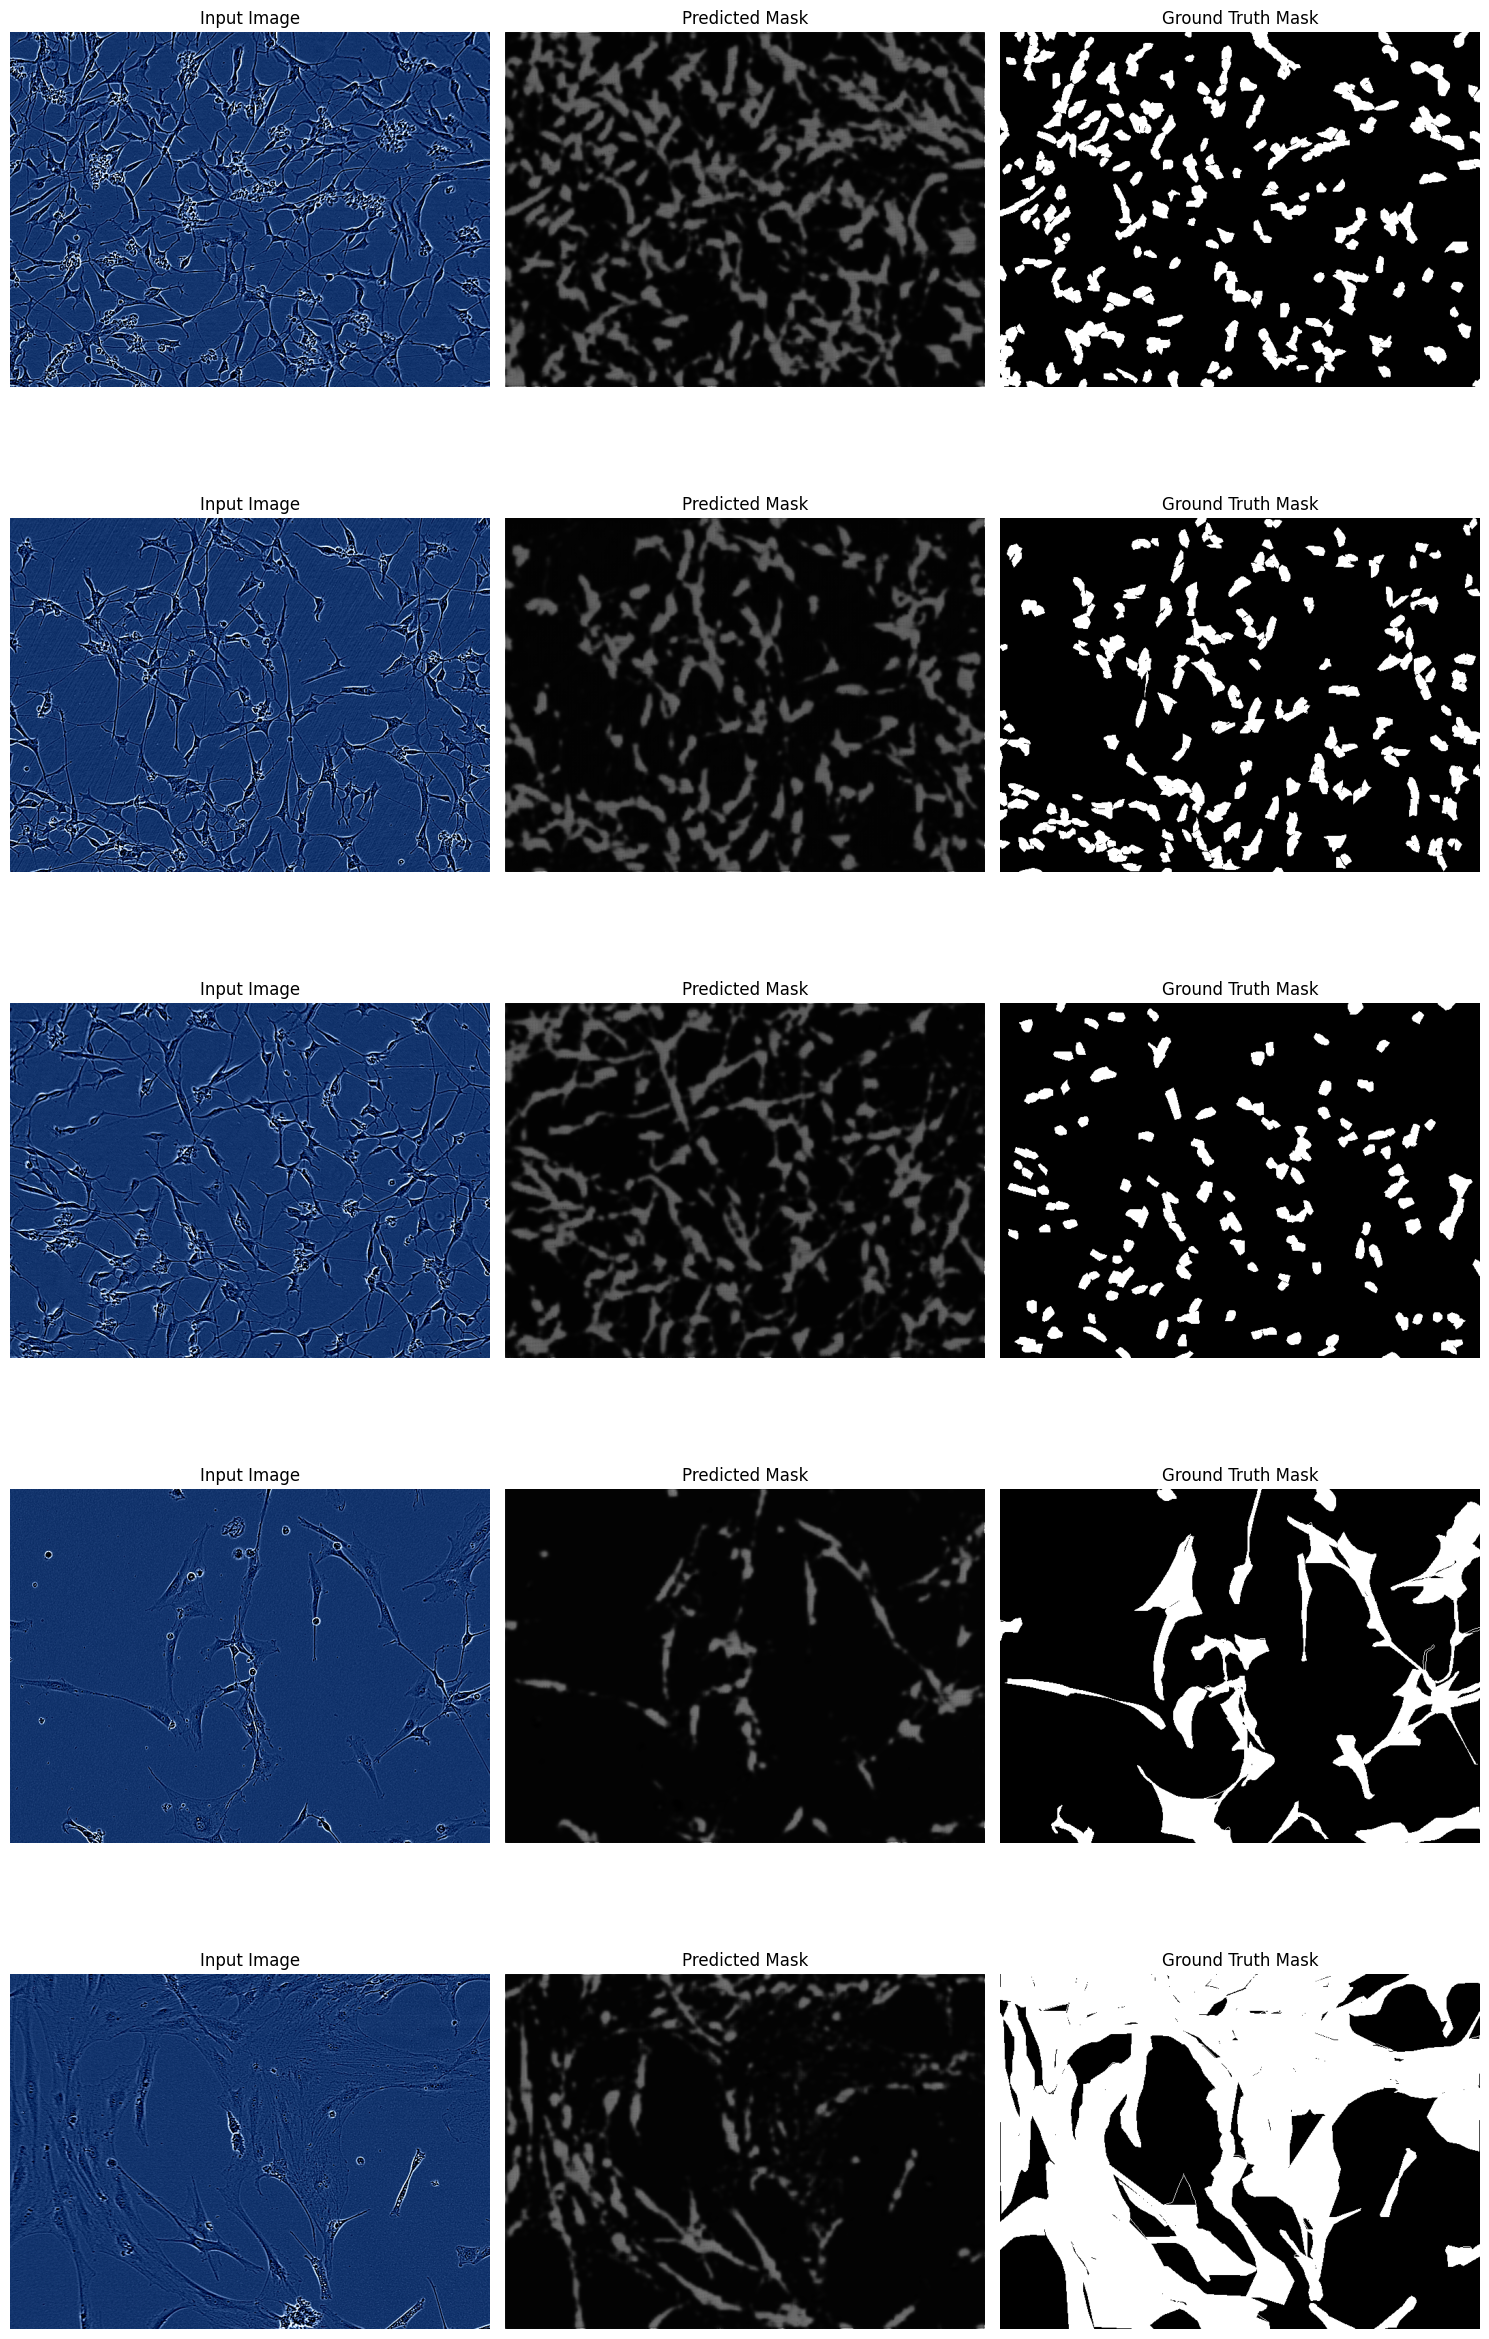

In [ ]:
# Example visualization using matplotlib
import matplotlib.pyplot as plt
import random

# Define the number of images to visualize
num_images_to_visualize = 5  # You can adjust this as needed

# Choose random sample indices within the bounds of the validation dataset
sample_indices = random.sample(range(num_val_samples), num_images_to_visualize)

# Plot each image along with its predicted mask and ground truth mask
plt.figure(figsize=(15, 5*num_images_to_visualize))
for i, sample_index in enumerate(sample_indices):
    plt.subplot(num_images_to_visualize, 3, i*3 + 1)
    plt.imshow(input_images[sample_index].transpose(1, 2, 0))  # Assuming images are in CHW format
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(num_images_to_visualize, 3, i*3 + 2)
    plt.imshow(predicted_masks[sample_index][0], cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.subplot(num_images_to_visualize, 3, i*3 + 3)
    plt.imshow(gt_masks[sample_index][0], cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


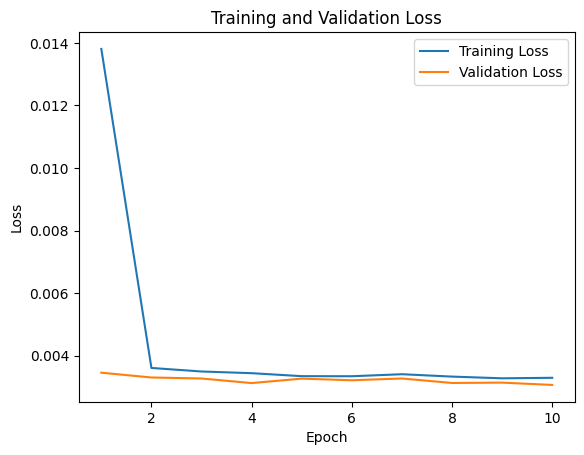

In [ ]:
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

torch.save(model.state_dict(), '/content/drive/MyDrive/ML_Project/kaku_model.pth')

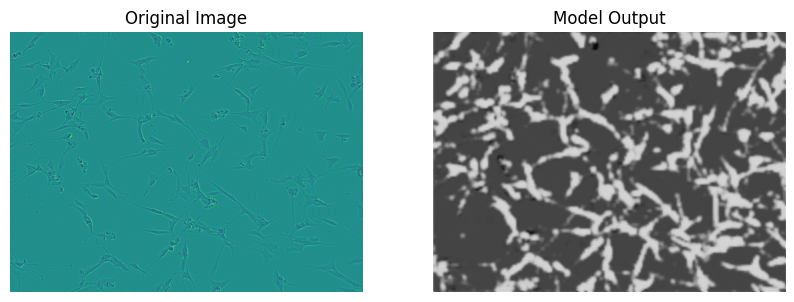

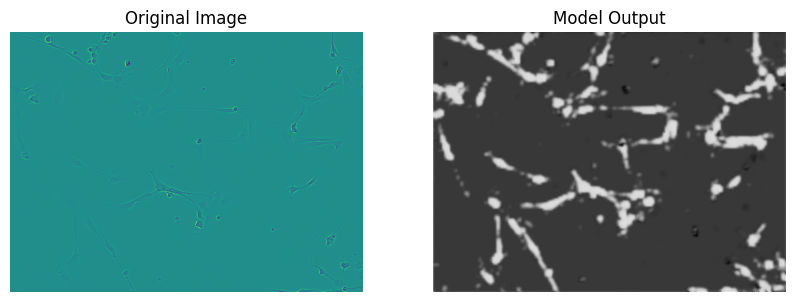

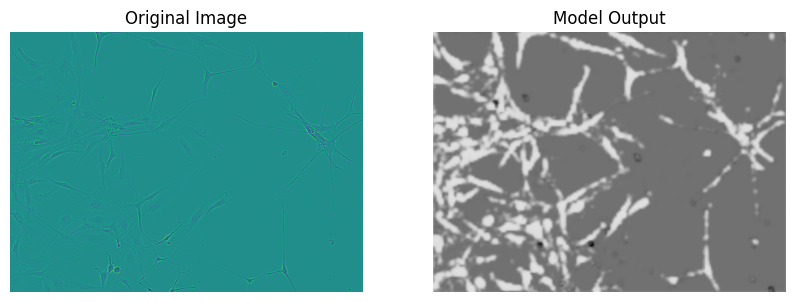

In [ ]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)
    return image

test_path = '/content/drive/MyDrive/ML_Project/sartorius-cell-instance-segmentation/test'
test_images = ['7ae19de7bc2a.png', 'd48ec7815252.png', 'd8bfd1dafdc4.png']

for test_image in test_images:
  input_image = preprocess_image(test_path + '/' + test_image)
  input_image = input_image.to(device)

  model.eval()
  model.to(device)

  with torch.no_grad():
      output = model(input_image)

  output_array = output.squeeze().cpu().numpy()

  original_image = Image.open(test_path + '/' + test_image)

  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].imshow(original_image)
  axes[0].set_title('Original Image')
  axes[0].axis('off')
  axes[1].imshow(output_array, cmap='gray')
  axes[1].set_title('Model Output')
  axes[1].axis('off')
  plt.show()



